# Dependencies

In [1]:
import os, warnings, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold


SEED = 0
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 160)

In [2]:
# Preprocess data
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()\

# Preprocess inputs
CLS = 0
PAD = 1
SEP = 2

def preprocess_roberta(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][:max_seq_len]
    attention_mask = encoded['attention_mask'][:max_seq_len]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def preprocess_roberta_tail(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][-max_seq_len:]
    attention_mask = encoded['attention_mask'][-max_seq_len:]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def get_data(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    y_data = []
    y_data_int = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])

        y_data.append(getattr(row, 'toxic'))
        y_data_int.append(getattr(row, 'toxic_int'))

    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    y_data = [np.asarray(y_data, dtype=np.float32), 
              np.asarray(y_data_int, dtype=np.int8)]
    
    return x_data, y_data
    
def get_data_valid(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    y_data = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])

        y_data.append(getattr(row, 'toxic'))

    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    y_data = np.asarray(y_data, dtype=np.int8)
    
    return x_data, y_data

def get_data_test(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])


    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    return x_data

# Parameters

In [3]:
MAX_LEN = 192
tokenizer_path = 'jplu/tf-xlm-roberta-large'

positive1 = 21384
positive2 = 112226

# Load data

In [4]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")

train_df = pd.concat([train1[['comment_text', 'toxic']].query('toxic == 1'),
                      train1[['comment_text', 'toxic']].query('toxic == 0').sample(n=positive1, random_state=SEED),
                      train2[['comment_text', 'toxic']].query('toxic > .5'),
                      train2[['comment_text', 'toxic']].query('toxic <= .5').sample(n=positive2, random_state=SEED)
                    ])
train_df = shuffle(train_df, random_state=SEED).reset_index(drop=True)
train_df['toxic_int'] = train_df['toxic'].round().astype(int)

print('Train samples %d' % len(train_df))
display(train_df.head())

Train samples 267220


,comment_text,toxic,toxic_int
0,It would be helpful if either story about this incident contained additional facts about what happened. Was the victim an innocent bystander? Did he provoke...,0.20000,0
1,What's missing in your stats is the percentage of Canadians who believed there was a clean exit to this mess. I'm not happy about the settlement but reco...,0.00000,0
2,Great another mediocre season.,0.60000,1
3,"Putting your money where your mouth is. Can't fault him for that, for sure. Oh, wait, that's right, he had no problem with sitting during the national ant...",0.65625,1
4,"Just call me Nemo....\n\nI'm writing about the H1B visa program and so is the author of the article. \n\nThere are 60,000 openings and evidently there will ...",0.00000,0


## Preprocess

In [5]:
train_df['comment_text'] = train_df.apply(lambda x: clean_text(x['comment_text']), axis=1)

# Tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Data generation sanity check

In [7]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 22
    comment_text = train_df['comment_text'].loc[idx]
    
    x_train, y_train = get_data(train_df[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta)
    
    print('label         : "%.4f"' % y_train[0])
    print('label int     : "%d"' % y_train[1])
    print('comment_text  : "%s"' % comment_text)
    print('input_ids     : "%s"' % x_train[0][0])
    print('attention_mask: "%s"' % x_train[1][0])
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len
    
    print('-------------------- TAIL --------------------')
    x_train, _ = get_data(train_df[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta_tail)
    
    print('input_ids     : "%s"' % x_train[0][0])
    print('attention_mask: "%s"' % x_train[1][0])
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len


Row 0
label         : "0.2000"
label int     : "0"
comment_text  : "It would be helpful if either story about this incident contained additional facts about what happened. Was the victim an innocent bystander? Did he provoke the suspects? Deal gone bad? It's hard to believe that after two days more isn't available."
input_ids     : "[    0  1650  2806   186 98893  2174 40101 13765  1672   903 45559 70541
   297 78301 15824     7  1672  2367 73659     5  5282     2]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]"
-------------------- TAIL --------------------
input_ids     : "[    0 90943 74955  6494    32  1650    25     7  7941    47 18822   450
  7103  6626 13312  1286 56112    25    18 19882     5     2]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]"

Row 1
label         : "0.0000"
label int     : "0"
comment_text  : "What's missing in your stats is the percentage of Canadians who believed there was a clean exit to this mess. I'm not happy about t

# 5-Fold split

In [8]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['toxic_int'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 213776, Validation size 53444
Fold: 2, Train size: 213776, Validation size 53444
Fold: 3, Train size: 213776, Validation size 53444
Fold: 4, Train size: 213776, Validation size 53444
Fold: 5, Train size: 213776, Validation size 53444


# Label distribution

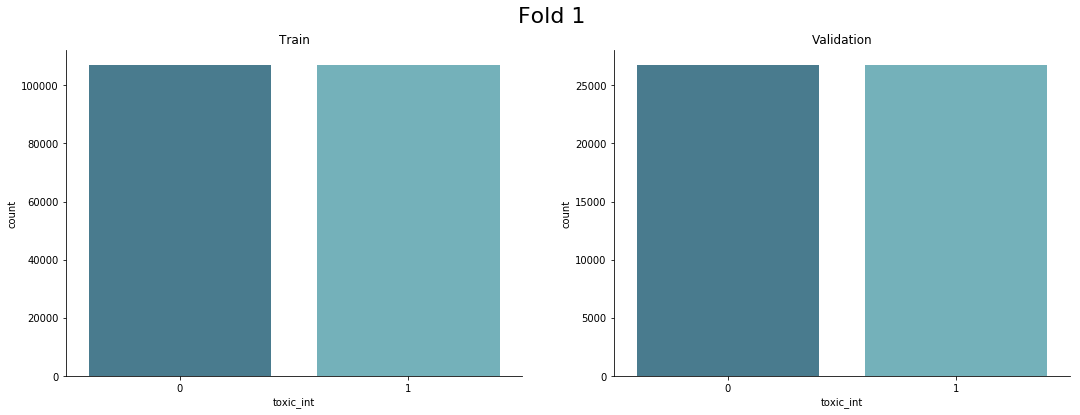

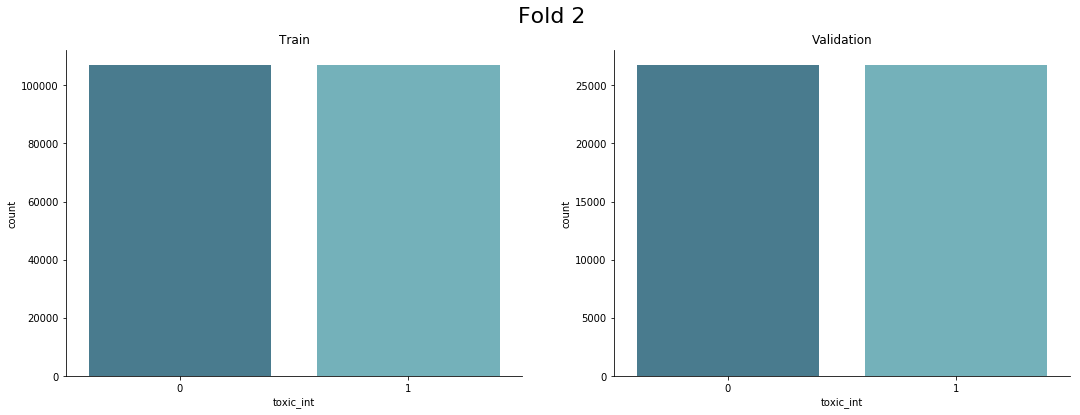

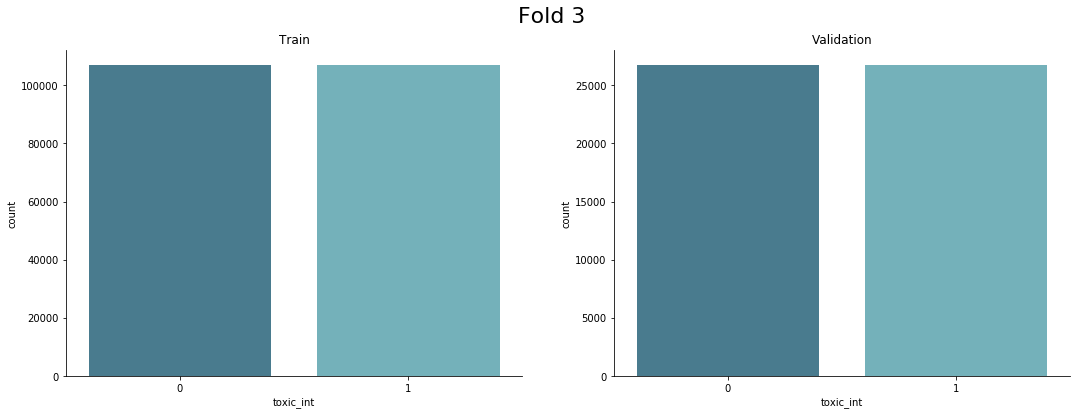

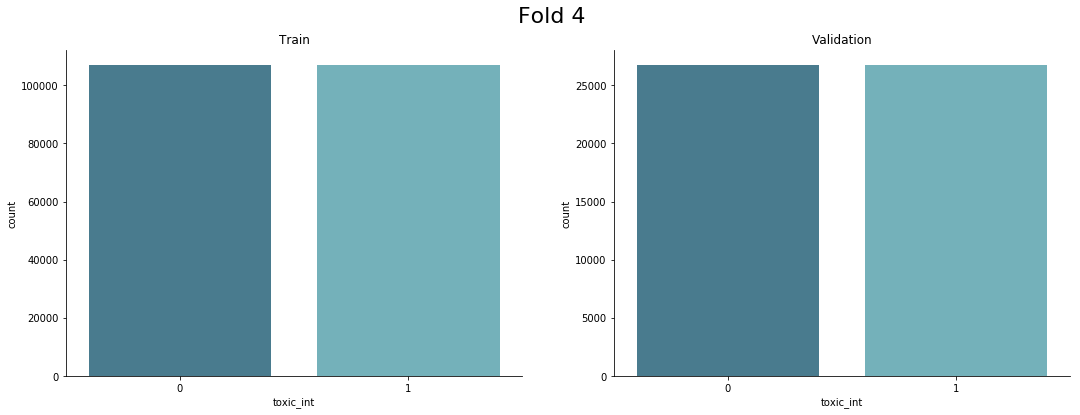

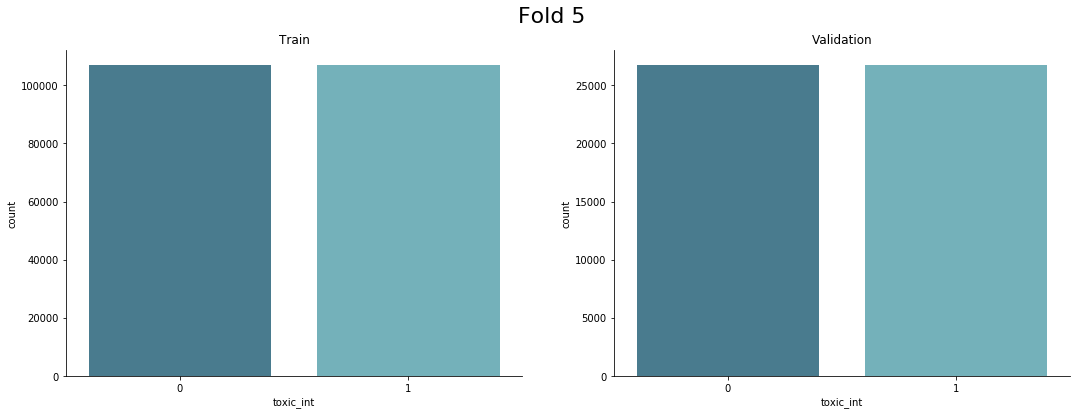

In [9]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="toxic_int", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", ax=ax1).set_title('Train')
    sns.countplot(x="toxic_int", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

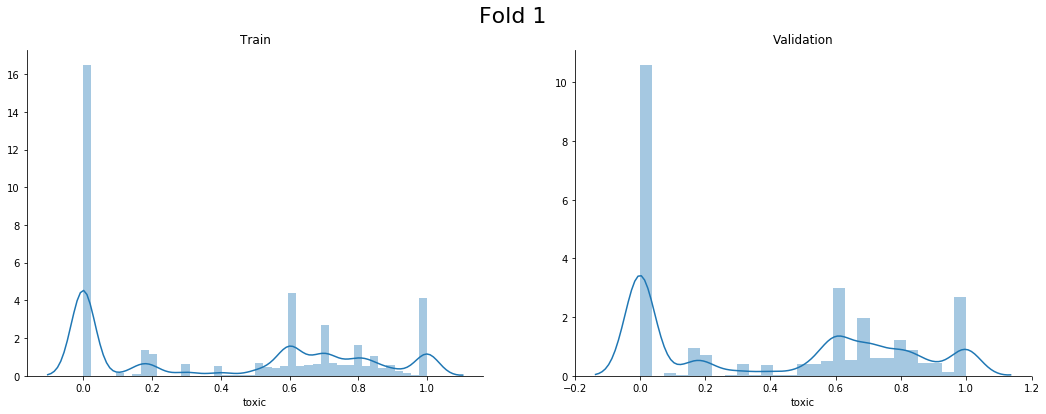

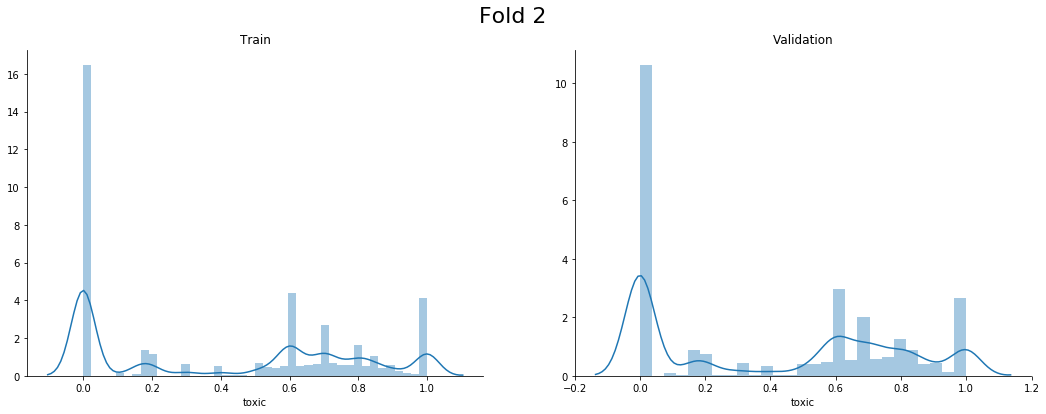

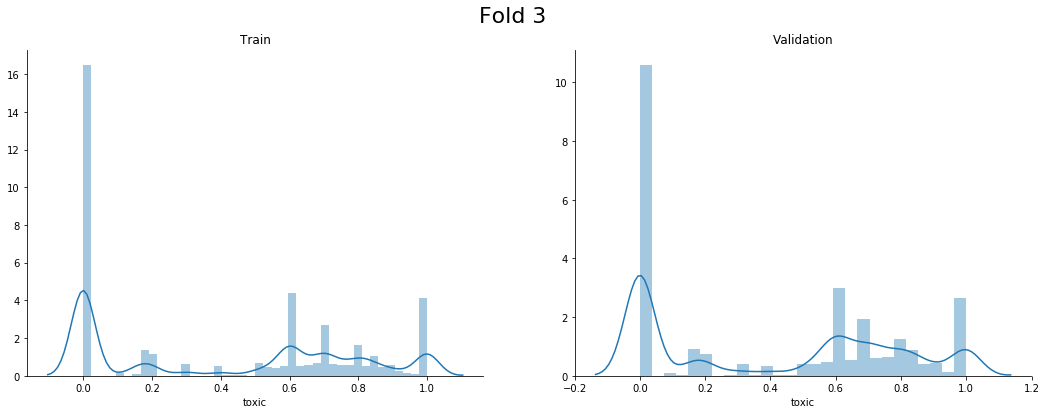

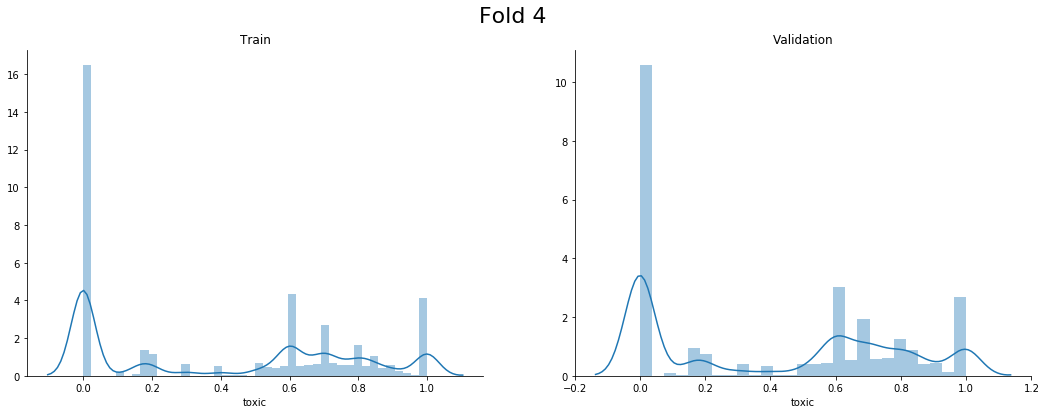

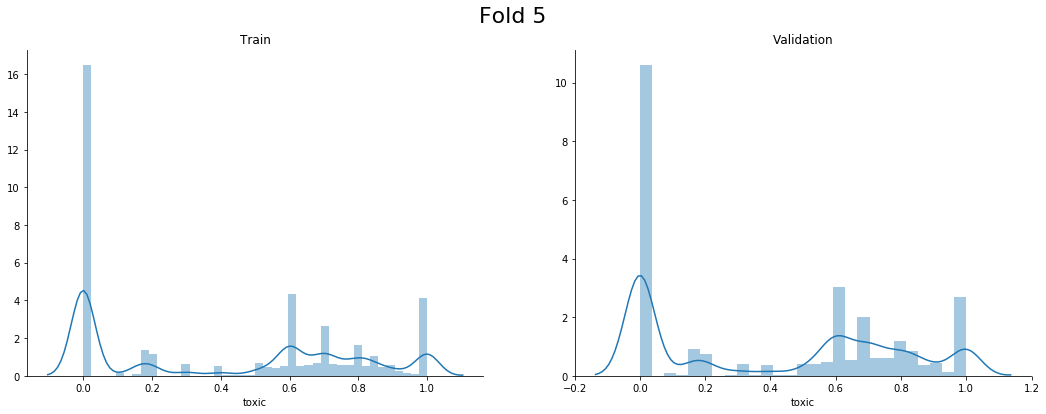

In [10]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['toxic'], ax=ax1).set_title('Train')
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['toxic'], ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

# Output 5-fold set

In [11]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    if fold_n < 2:
        fold_n += 1
        base_path = 'fold_%d/' % fold_n

        # Create dir
        os.makedirs(base_path)

        x_train, y_train = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
        x_valid, y_valid = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], 'comment_text', 
                                    tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
        y_train_float, y_train_int = y_train
        y_valid_float, y_valid_int = y_valid
        x_train, y_train_float, y_train_int =  np.asarray(x_train), np.asarray(y_train_float), np.asarray(y_train_int)
        x_valid, y_valid_float, y_valid_int =  np.asarray(x_valid), np.asarray(y_valid_float), np.asarray(y_valid_int)
        
        np.save(base_path + 'x_train', x_train)
        np.save(base_path + 'y_train', y_train_float)
        np.save(base_path + 'y_train_int', y_train_int)
        np.save(base_path + 'x_valid', x_valid)
        np.save(base_path + 'y_valid', y_valid_float)
        np.save(base_path + 'y_valid_int', y_valid_int)

        print('\nFOLD: %d' % (fold_n))
        print('x_train shape:', x_train.shape)
        print('y_train_float shape:', y_train_float.shape)
        print('y_train_int shape:', y_train_int.shape)
        print('x_valid shape:', x_valid.shape)
        print('y_valid_float shape:', y_valid_float.shape)
        print('y_valid_int shape:', y_valid_int.shape)
        
        #################### ENCODE TAIL ONLY ####################

        x_train, _ = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], 'comment_text', 
                              tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
        x_valid, _ = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], 'comment_text', 
                              tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
        x_train = np.asarray(x_train)
        x_valid = np.asarray(x_valid)
        
        np.save(base_path + 'x_train_tail', x_train)
        np.save(base_path + 'x_valid_tail', x_valid)

        print('\nFOLD: %d [TAIL]' % (fold_n))
        print('x_train shape:', x_train.shape)
        print('x_valid shape:', x_valid.shape)

#  Compress logs dir
!tar -cvzf fold_1.tar.gz fold_1
!tar -cvzf fold_2.tar.gz fold_2
# !tar -cvzf fold_3.tar.gz fold_3
# !tar -cvzf fold_4.tar.gz fold_4
# !tar -cvzf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
shutil.rmtree('fold_2')
# shutil.rmtree('fold_3')
# shutil.rmtree('fold_4')
# shutil.rmtree('fold_5')

,comment_text,toxic,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,It would be helpful if either story about this incident contained additional facts about what happened. Was the victim an innocent bystander? Did he provoke...,0.20000,0,train,train,validation,train,train
1,What's missing in your stats is the percentage of Canadians who believed there was a clean exit to this mess. I'm not happy about the settlement but recogni...,0.00000,0,train,train,validation,train,train
2,Great another mediocre season.,0.60000,1,train,train,validation,train,train
3,"Putting your money where your mouth is. Can't fault him for that, for sure. Oh, wait, that's right, he had no problem with sitting during the national anthe...",0.65625,1,validation,train,train,train,train
4,"Just call me Nemo.... I'm writing about the HB visa program and so is the author of the article. There are , openings and evidently there will continue to b...",0.00000,0,train,train,train,train,validation



FOLD: 1
x_train shape: (2, 213776, 192)
y_train_float shape: (213776,)
y_train_int shape: (213776,)
x_valid shape: (2, 53444, 192)
y_valid_float shape: (53444,)
y_valid_int shape: (53444,)

FOLD: 1 [TAIL]
x_train shape: (2, 213776, 192)
x_valid shape: (2, 53444, 192)

FOLD: 2
x_train shape: (2, 213776, 192)
y_train_float shape: (213776,)
y_train_int shape: (213776,)
x_valid shape: (2, 53444, 192)
y_valid_float shape: (53444,)
y_valid_int shape: (53444,)

FOLD: 2 [TAIL]
x_train shape: (2, 213776, 192)
x_valid shape: (2, 53444, 192)
fold_1/
fold_1/y_valid_int.npy
fold_1/y_train_int.npy
fold_1/x_valid.npy
fold_1/x_valid_tail.npy
fold_1/y_valid.npy
fold_1/x_train_tail.npy
fold_1/y_train.npy
fold_1/x_train.npy
fold_2/
fold_2/y_valid_int.npy
fold_2/y_train_int.npy
fold_2/x_valid.npy
fold_2/x_valid_tail.npy
fold_2/y_valid.npy
fold_2/x_train_tail.npy
fold_2/y_train.npy
fold_2/x_train.npy


# Validation set

In [12]:
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])
# Preprocess
valid_df['comment_text'] = valid_df.apply(lambda x: clean_text(x['comment_text']), axis=1)
display(valid_df.head())

x_valid, y_valid = get_data_valid(valid_df, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
x_valid, y_valid = np.asarray(x_valid), np.asarray(y_valid)

np.save('x_valid', x_valid)
np.save('y_valid', y_valid)
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)

#################### ENCODE TAIL ONLY ####################

x_valid, _ = get_data_valid(valid_df, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
x_valid =  np.asarray(x_valid)

np.save('x_valid_tail', np.asarray(x_valid))
print('[TAIL] x_valid shape:', x_valid.shape)

,comment_text,lang,toxic
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purificar su alma y nuestro aparato digestivo media...,es,0
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, nel fare cio .",it,0
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder años a nivel particular. Las volveria a pasar putas.Fe...",es,1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siyaset bilimi ana başlığından sonra siyasal ...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecekte(- yıl) bu tip şeyler düşünüyorum. Tab...,tr,0


x_valid shape: (2, 8000, 192)
y_valid shape: (8000,)
[TAIL] x_valid shape: (2, 8000, 192)


# Test set

In [13]:
test_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv", usecols=['content'])
# Preprocess
test_df['content'] = test_df.apply(lambda x: clean_text(x['content']), axis=1)
display(test_df.head())

x_test = get_data_test(test_df, 'content', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
x_test = np.asarray(x_test)

np.save('x_test', x_test)
print('x_test shape:', x_test.shape)

#################### ENCODE TAIL ONLY ####################

x_test = get_data_test(test_df, 'content', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
x_test = np.asarray(x_test)

np.save('x_test_tail', x_test)
print('[TAIL] x_test shape:', x_test.shape)

,content
0,Doctor Who adlı viki başlığına . doctor olarak bir viki yazarı kendi adını eklemiştir. Şahsen düzelttim. Onaylarsanız sevinirim. Occipital
1,"Вполне возможно, но я пока не вижу необходимости выделять материал в отдельную статью. Если про правосудие в СССР будет написано хотя бы килобайт - — тогда ..."
2,"Quindi tu sei uno di quelli conservativi , che preferiscono non cancellare. Ok. Avresti lasciato anche sfaccimma ? Si? Ok. Contento te... io non approvo per..."
3,Malesef gerçekleştirilmedi ancak şöyle bir şey vardı. Belki yararlanırsınız. İyi çalışmalar. Kud yaz Teşekkür ederim. Abidenin maddesini de genişletmeyi düş...
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu :Resim:Seldabagcan.jpg resmini yüklediğiniz için teşekkürler. Ancak dosyanın tanım sayfasında içeriğin kimin t...


x_test shape: (2, 63812, 192)
[TAIL] x_test shape: (2, 63812, 192)
